## Check individual items

#### The step after EDA

#### Dataset description:
The cleaned dataset contain data from July to Sep

### Rule:
There are three rules: see below.

#### Next step: 
**Inventory Segmentation within each calss**:  (since Different items have different price, sale qty and margin rate, therefore, we should consider different weight for different group) 

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
import plotly.express as px
import plotly.graph_objects as go
import warnings
from Inventory_opti_helperFunction import *
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style("whitegrid")

In [2]:
import findspark
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import *
# Import SparkSession
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
import re

findspark.init()

"""
Build the SparkSession
"""
# getOrCreate(): get the current Spark session or to create one if there is none running
spark = SparkSession.builder \
   .master("local") \
   .appName("Linear Regression Model") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
   
sc = spark.sparkContext # create a SparkSession object from your SparkContext

# Verify SparkContext
print(sc)

# Print Spark version
print(sc.version)

<SparkContext master=local appName=Linear Regression Model>
2.4.4


In [3]:
df = spark.read.csv("../data/CleanedData/month_merge_total.csv", header=True)

In [4]:
df = df.select("SKU", 'avgNetSale', 'avgQtySold', 'avgPrice','avgSellMargin',
              'Classification', 'Facings','Capacity','month')

# clean data
# Conver columns to `FloatType()`
df = df.withColumn("avgNetSale", df.avgNetSale.cast('float')).withColumnRenamed("avgNetSale", "totalNetSale")
df = df.withColumn("avgQtySold", df.avgQtySold.cast('float')).withColumnRenamed("avgQtySold", "totalQtySold")
df = df.withColumn("avgPrice", df.avgPrice.cast('float')).withColumnRenamed("avgPrice", "Price")
df = df.withColumn("avgSellMargin", df.avgSellMargin.cast('float')).withColumnRenamed("avgSellMargin", "SellMargin")
df = df.withColumn("Facings", df.Facings.cast('float'))
df = df.withColumn("Capacity", df.Capacity.cast('float'))

In [5]:
df.printSchema()

root
 |-- SKU: string (nullable = true)
 |-- totalNetSale: float (nullable = true)
 |-- totalQtySold: float (nullable = true)
 |-- Price: float (nullable = true)
 |-- SellMargin: float (nullable = true)
 |-- Classification: string (nullable = true)
 |-- Facings: float (nullable = true)
 |-- Capacity: float (nullable = true)
 |-- month: string (nullable = true)



In [6]:
## Summary Statistics
# This will give a quick glimpse to data, if columns are not mentioned all the numeric columns stats are produced 
columns_to_analyze=['Facings','Capacity','totalQtySold','SellMargin']
df.select(*[columns_to_analyze]).describe().show()

+-------+-----------------+------------------+------------------+------------------+
|summary|          Facings|          Capacity|      totalQtySold|        SellMargin|
+-------+-----------------+------------------+------------------+------------------+
|  count|             2223|              2223|              2223|              2223|
|   mean|4.902384165542061| 21.95906432748538| 59.66239316110615|1862.6278030869128|
| stddev|5.120589795887871|30.470650136421174|165.12674279980433| 4489.860177033874|
|    min|              1.0|               1.0|               1.0|           -269.64|
|    max|             44.0|             370.0|            2233.0|         53821.047|
+-------+-----------------+------------------+------------------+------------------+



In [7]:
pdf = df.toPandas() # creat panda object for ploting

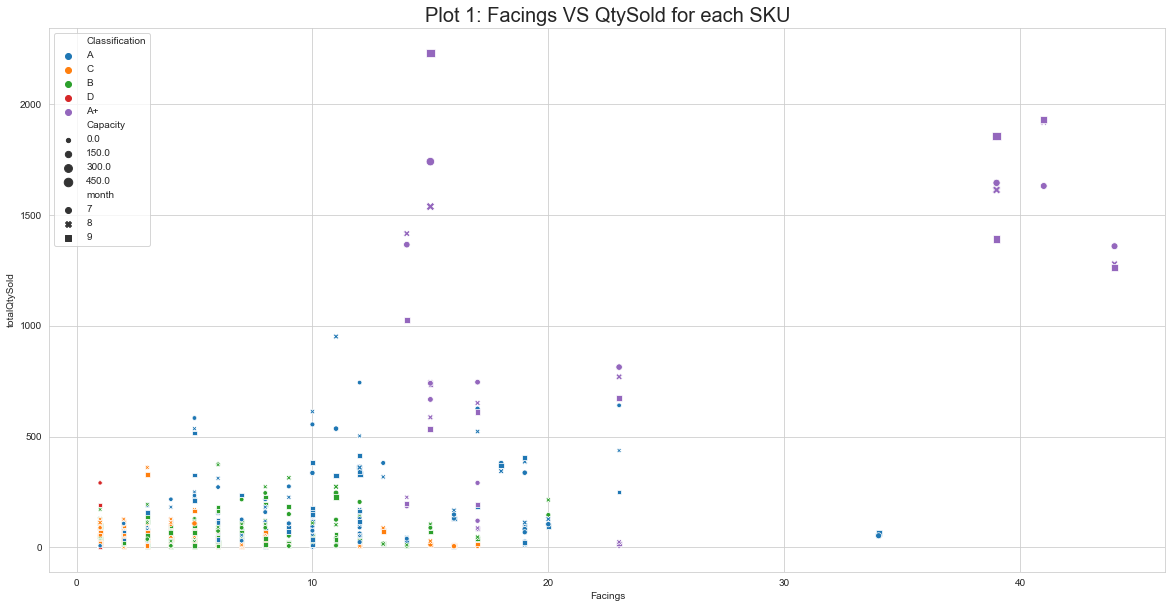

In [8]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x="Facings", y="totalQtySold", hue = "Classification", style = 'month',
                     size = 'Capacity', data=pdf)
ax.set_title("Plot 1: Facings VS QtySold for each SKU", fontsize=20)
#plt.xlim(0,0.006)
#plt.ylim(0,0.025)
plt.show()

## Rule 1: Identify high facing items
based on `plot 1`:

Some `A` items facing is above 95% items, but qty sold is less than 85% items: <br />

**The `average facing` of items which from the same classification and has `similar price` and `similar sale qty`**.

The 95% facing is 13.0
The 85% qty sold is 78.0


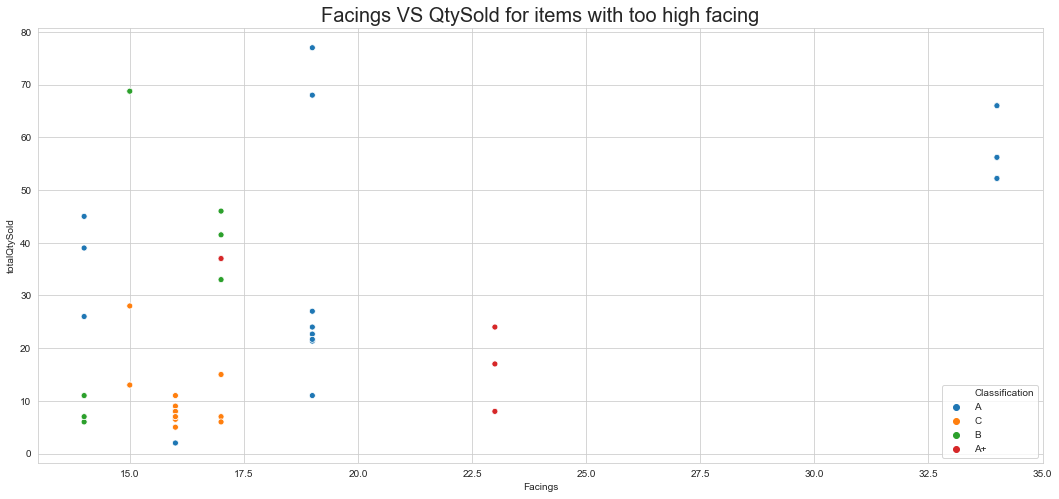

In [9]:
high_facing = find_too_high_facing_items(df, class_choice = 'Classification')

## Rule 2: Identify low qty sold & high facing items 
based on `plot 1` and table below, we can see that 25% items have no more than 6 total sells. 

Report items which (Rule 2):
- facing is more than monthly sold qty: for example, monthly sold qty is 1, but facing is 2.

There are 100 items satisfy this condition


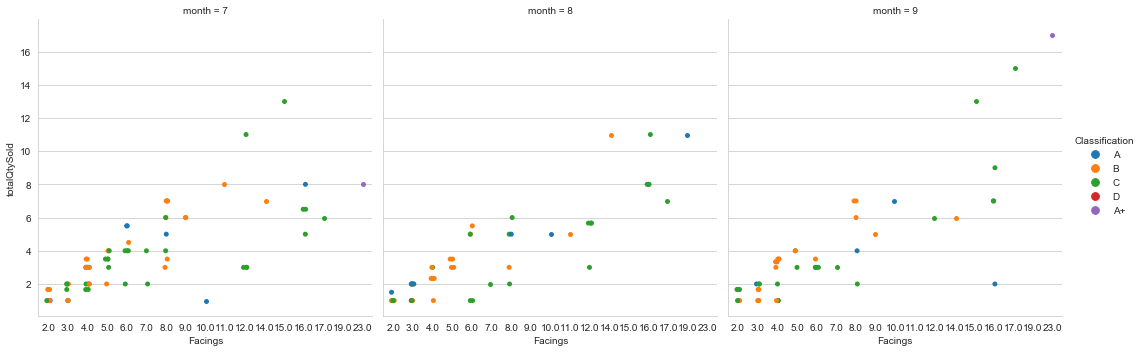

There are 13 items satisfy this condition in three month


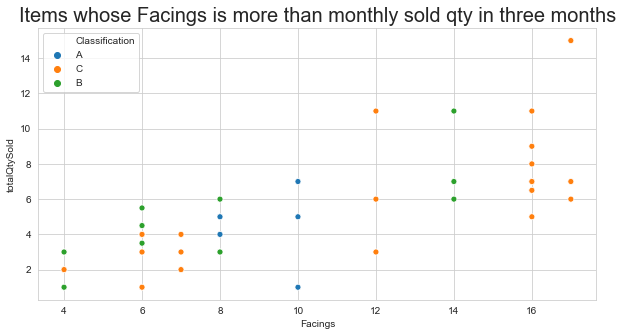

In [21]:
qty_less_than_facing = find_monthly_qty_less_items(df, 'Facings')

In [11]:
qty_less_than_facing.select("Facings","totalQtySold").show()

+-------+------------+
|Facings|totalQtySold|
+-------+------------+
|   10.0|         7.0|
|   16.0|         8.0|
|    2.0|   1.6666666|
|    2.0|   1.6666666|
|    2.0|   1.6666666|
|    3.0|         2.0|
|    6.0|         5.5|
|    9.0|         6.0|
|    8.0|         2.0|
|   16.0|         9.0|
|    2.0|         1.0|
|    8.0|         3.5|
|    8.0|         7.0|
|    4.0|         3.0|
|    3.0|         1.0|
|   16.0|         8.0|
|   16.0|         8.0|
|    8.0|         6.0|
|    2.0|         1.0|
|    4.0|   1.6666666|
+-------+------------+
only showing top 20 rows



## Rule 3: Identify low qty sold & high Capacity items 
based on `plot 1` and table below, we can see that 25% items have no more than 6 total sells. 

Report items which (Rule 2):
- capacity is more than monthly total sold qty: for example, monthly sold qty is 1, but capacity is 2.

There are 322 items satisfy this condition


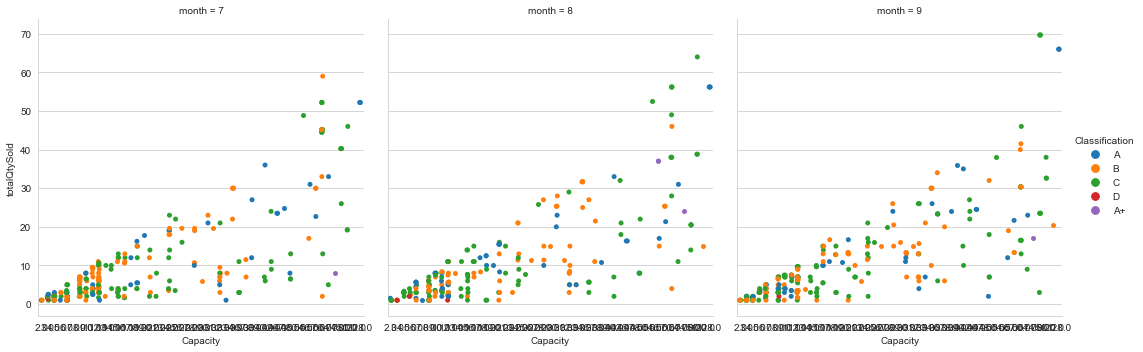

There are 112 items satisfy this condition in three month


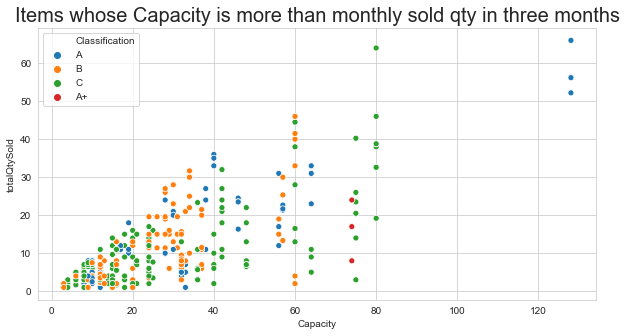

In [12]:
qty_less_than_capacity = find_monthly_qty_less_items(df, 'Capacity')

In [13]:
qty_less_than_facing.select("Capacity","totalQtySold").show()

+--------+------------+
|Capacity|totalQtySold|
+--------+------------+
|    33.0|         7.0|
|    48.0|         8.0|
|     6.0|   1.6666666|
|     6.0|   1.6666666|
|     6.0|   1.6666666|
|    12.0|         2.0|
|    18.0|         5.5|
|     9.0|         6.0|
|    24.0|         2.0|
|    64.0|         9.0|
|     6.0|         1.0|
|    24.0|         3.5|
|    40.0|         7.0|
|    20.0|         3.0|
|     6.0|         1.0|
|    48.0|         8.0|
|    48.0|         8.0|
|    32.0|         6.0|
|     8.0|         1.0|
|    16.0|   1.6666666|
+--------+------------+
only showing top 20 rows



### Merge rule 1, rule 2 and rule 3 result to one dataframe
Since these two rules has overlap

In [14]:
high_facing_output = high_facing.join(qty_less_than_facing, on=["SKU",'month','Facings','Capacity',
                                                               'totalQtySold','Price','SellMargin'], how="full")
high_facing_output = high_facing_output.join(qty_less_than_capacity, on=["SKU",'month','Facings','Capacity',
                                                               'totalQtySold','Price','SellMargin'], how="full")
high_facing_output = high_facing_output.select('SKU', 'month','Facings','Capacity',
                                               'totalQtySold','Price','SellMargin')
high_facing_output.toPandas().to_csv('../data/Output/qty_less_than_capacity_and_qty_less_than_facing_SKU.csv', 
                             index=False, encoding='utf-8')

In [15]:
count = df.select("SKU").distinct().count()
print("There are {} items total".format(count))

There are 604 items total


## Rule 4 :
Facing > (monthly total sold qty *2)

There are 31 items satisfy this condition


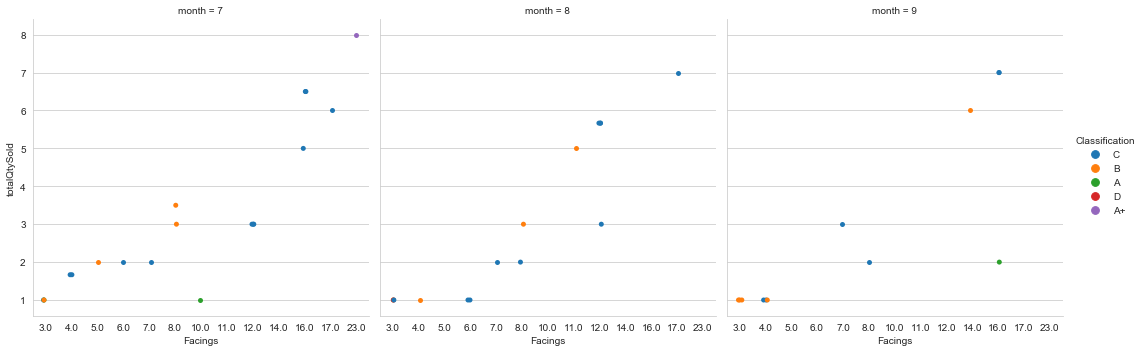

There are 0 items satisfy this condition in three month


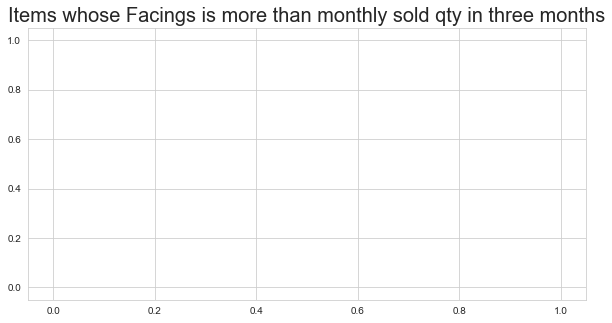

In [16]:
qty_less_than_facing2 = find_monthly_qty_less_items(df, 'Facings', 2)

In [17]:
qty_less_than_facing2.toPandas().to_csv('../data/Output/facing2_SKU.csv', 
                             index=False, encoding='utf-8')

## Rule 5 :
Capacity > monthly total sold qty *4

There are 78 items satisfy this condition


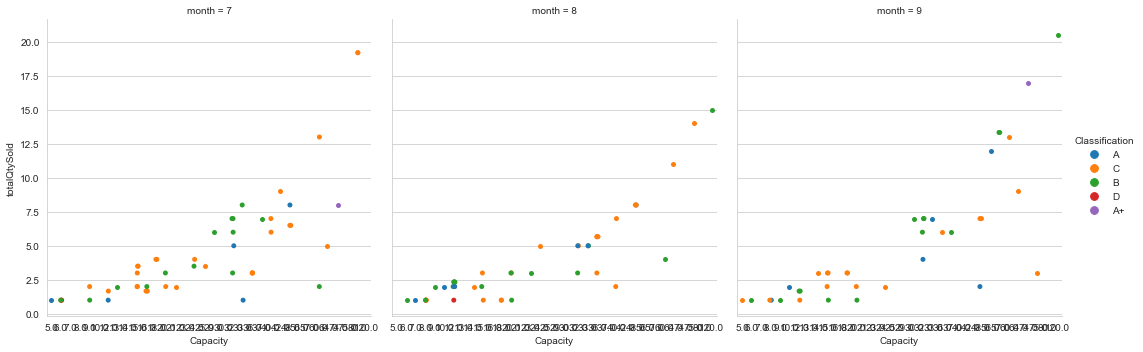

There are 9 items satisfy this condition in three month


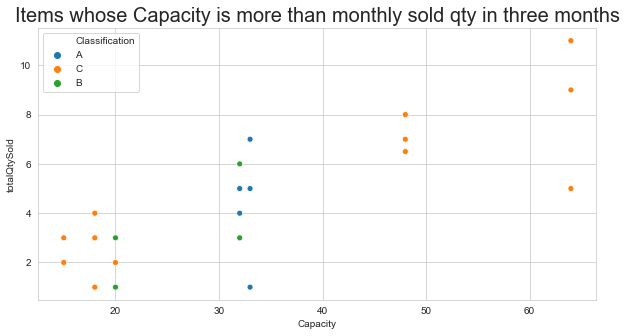

In [18]:
qty_less_than_capacity4 = find_monthly_qty_less_items(df, 'Capacity', 4)

In [19]:
qty_less_than_capacity4.toPandas().to_csv('../data/Output/capacity4_SKU.csv', 
                             index=False, encoding='utf-8')